In [1]:
import os

In [ ]:
repo_folder_path = '~/STCarotidSeg4D'
os.chdir(repo_folder_path)

In [ ]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from pathlib import Path


import seaborn as sns
import seaborn_image as isns
from matplotlib.colors import CenteredNorm, ListedColormap

import transforms

In [4]:
pd.options.mode.copy_on_write = True

##### Result File Paths

In [ ]:
test_data_directory = "~/data/TestData"
model_output_directory = "~/output/"

In [6]:
test_images = {
    "magnitude": f"{test_data_directory}/2dtime_PCMRI/images",
    "velocities": f"{test_data_directory}/Velocities/images/",
}

test_labels = {
    "magnitude": f"{test_data_directory}/2dtime_PCMRI/labels/",
    "velocities": f"{test_data_directory}/Velocities/labels/",
}


In [9]:
# Path to save images
save_path = Path(
    f"{repo_folder_path}/notebooks/generated_images/evaluation"
)
save_path.mkdir(exist_ok=True, parents=True)

# Evaluation Data (post-processed)
df = pd.read_excel(
    f"{model_output_directory}/UNet3D/velocities/Interp_16/evaluation_ensemble/data.xlsx"
)

# Evaluation Data (raw)
df_raw = pd.read_excel(
    f"{model_output_directory}/UNet3D/velocities/Interp_16/evaluation_ensemble_raw/data.xlsx"
)

# Filter columns
flow_df_raw = df_raw[
    [
        "sample",
        "time_step",
        "gt_flow_rate",
        "gt_lumen_diameter",
        "pred_flow_rate",
        "pred_lumen_diameter",
        "gt_max_velocity",
        "pred_max_velocity",
    ]
]
flow_df_orig = df[
    [
        "sample",
        "time_step",
        "gt_flow_rate",
        "pred_flow_rate",
        "gt_lumen_diameter",
        "pred_lumen_diameter",
        "gt_max_velocity",
        "pred_max_velocity",
    ]
]

#### Lumen, Flow Rate, Max Velocity Distributions

In [12]:
(Path(save_path) / 'distributions').mkdir(exist_ok=True, parents=True)

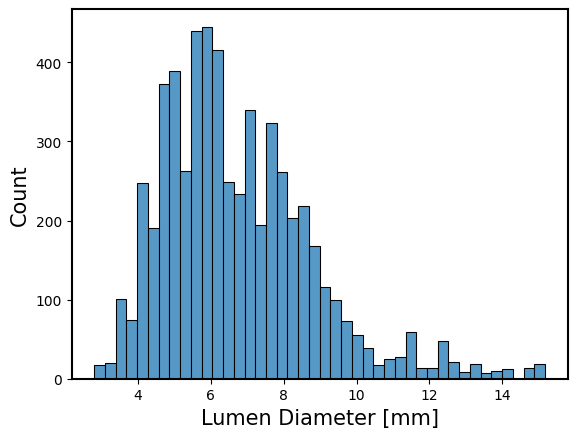

In [13]:
ax = sns.histplot(data=flow_df_raw, x='gt_lumen_diameter')
ax.set(xlabel = "Lumen Diameter [mm]")
plt.savefig(Path(save_path) / 'distributions' / 'lumen_diameter_dist.svg')

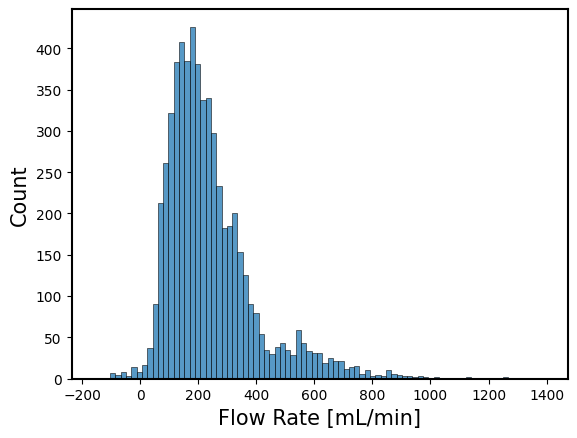

In [14]:
ax = sns.histplot(data=flow_df_raw, x='gt_flow_rate')
ax.set(xlabel = "Flow Rate [mL/min]")
plt.savefig(Path(save_path) / 'distributions' / 'flow_rate_dist.svg')

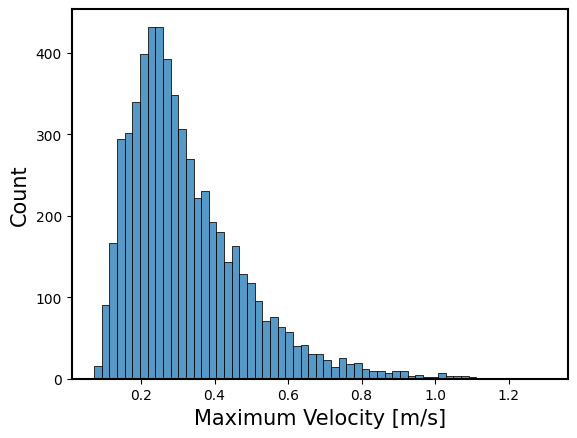

In [15]:
ax = sns.histplot(data=flow_df_raw, x='gt_max_velocity')
ax.set(xlabel = "Maximum Velocity [m/s]")
plt.savefig(Path(save_path) / 'distributions' / 'max_velocity_dist.svg')

### Systolic vs Diastolic Error

Systolic: first 40%
Diastolic: Last 60%


In [16]:
def get_systole(arr: np.ndarray, pct=0.4):
    len_systole = int(np.ceil(len(arr) * pct))
    return arr[:len_systole]

In [17]:
def get_diastole(arr: np.ndarray, systole_pct: float = 0.4):
    len_diastole = int(np.floor(len(arr) * (1 - systole_pct)))
    return arr[-len_diastole:]

In [18]:
def relative_error(pred_arr: np.ndarray, gt_arr: np.ndarray):
    return np.abs((pred_arr - gt_arr) / gt_arr)

In [19]:
# for the y-ticks
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [20]:
def systolic_diastolic_comp(
    flow_df: pd.DataFrame,
    gt_key: str,
    pred_key: str,
    metric_name: str,
    save_path: os.PathLike,
    clip=False,
):
    relative_errors_systole = []
    relative_errors_diastole = []

    d = {"sample": flow_df_orig["sample"].unique()}

    for sample in d["sample"]:
        gt_flow_rates = flow_df_orig[flow_df_orig["sample"] == sample][gt_key]
        pred_flow_rates = flow_df_orig[flow_df_orig["sample"] == sample][
            pred_key
        ]

        systole_gt_flow_rate = get_systole(gt_flow_rates)
        systole_pred_flow_rate = get_systole(pred_flow_rates)
        rel_err_sys = relative_error(
            systole_gt_flow_rate, systole_pred_flow_rate
        ).mean()
        if (rel_err_sys >= 1).any():
            print(f"Outlier in systole, {rel_err_sys * 100:.2f}%")
        relative_errors_systole.append(rel_err_sys)

        diastole_gt_flow_rate = get_diastole(gt_flow_rates)
        diastole_pred_flow_rate = get_diastole(pred_flow_rates)
        rel_err_dia = relative_error(
            diastole_gt_flow_rate, diastole_pred_flow_rate
        ).mean()
        if (rel_err_dia >= 1).any():
            print(f"Outlier in diastole, {rel_err_dia * 100:.2f}%")
        relative_errors_diastole.append(rel_err_dia)

    print(
        f"Average err. systole: {np.array(relative_errors_systole).mean() * 100:.3f} %"
    )
    print(
        f"Average err. diastole: {np.array(relative_errors_diastole).mean() * 100:.3f} %"
    )

    if clip:
        relative_errors_diastole = np.array(relative_errors_diastole).clip(0, 1) * 100
        relative_errors_systole = np.array(relative_errors_systole).clip(0, 1) * 100
    else:
        relative_errors_diastole = np.array(relative_errors_diastole) * 100
        relative_errors_systole = np.array(relative_errors_systole) * 100

    d["rel_err_systole"] = relative_errors_systole
    d["rel_err_diastole"] = relative_errors_diastole

    sns.boxplot(
        y=relative_errors_diastole, x=["Diastolic"] * len(relative_errors_diastole)
    )
    ax = sns.boxplot(
        y=relative_errors_systole, x=["Systolic"] * len(relative_errors_systole)
    )
    ax.set(ylabel=f"$\epsilon_{{rel}}$ {metric_name} [%]")
    largest_error = np.max([relative_errors_diastole.max(), relative_errors_systole.max()])
    ax.set(yticks=np.arange(0, roundup(largest_error)+1, 10))
    save_dir = Path(save_path) / "error_analysis" / "cardiac_cycle"
    save_dir.mkdir(exist_ok=True, parents=True)
    plt.savefig(Path(save_dir) / f"sys_dia_{'_'.join(metric_name.lower().split(' '))}.svg")

Outlier in diastole, 153.04%
Outlier in diastole, 261.80%
Outlier in diastole, 434.10%
Average err. systole: 7.653 %
Average err. diastole: 9.478 %


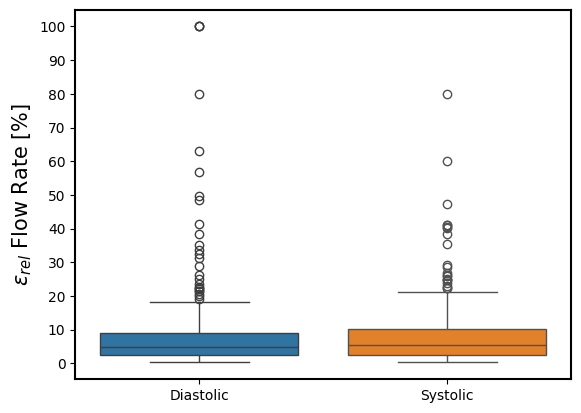

In [21]:
systolic_diastolic_comp(
    flow_df=flow_df_raw,
    gt_key='gt_flow_rate',
    pred_key='pred_flow_rate',
    metric_name='Flow Rate',
    save_path=save_path,
    clip=True
)

Outlier in diastole, 111.38%
Outlier in diastole, 156.60%
Outlier in diastole, 168.47%
Average err. systole: 1.254 %
Average err. diastole: 4.800 %


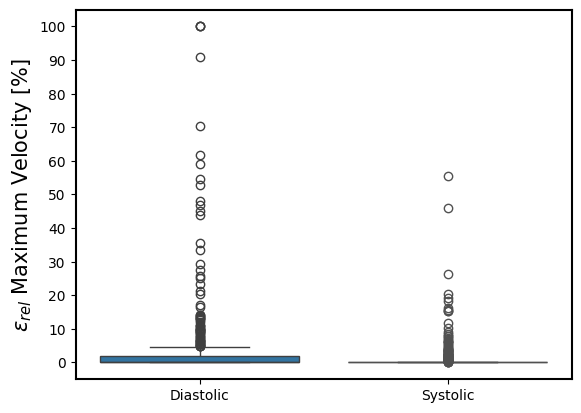

In [22]:
systolic_diastolic_comp(
    flow_df=flow_df_raw,
    gt_key='gt_max_velocity',
    pred_key='pred_max_velocity',
    metric_name='Maximum Velocity',
    save_path=save_path,
    clip=True
)

Average err. systole: 10.122 %
Average err. diastole: 10.097 %


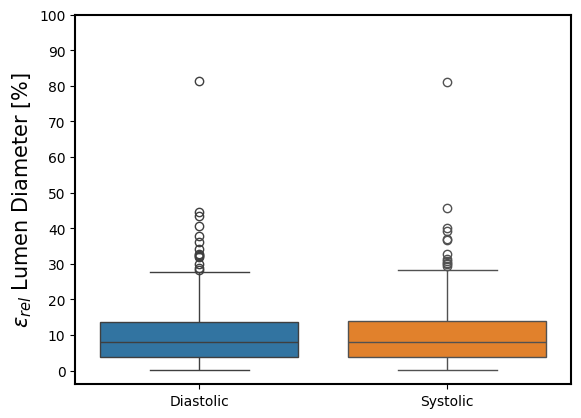

In [23]:
systolic_diastolic_comp(
    flow_df=flow_df_raw,
    gt_key='gt_lumen_diameter',
    pred_key='pred_lumen_diameter',
    metric_name='Lumen Diameter',
    save_path=save_path,
    clip=True
)

### Outliers

In [24]:
from skimage import measure
from scipy.interpolate import splprep, splev

In [25]:
def smooth_contour(contour, smoothness=5.0, num_points=1000):
    """
    Smooth a closed contour using a periodic B-spline.
    source: https://agniva.me/scipy/2016/10/25/contour-smoothing.html

    Parameters:
        contour: ndarray of shape (N, 2)
            The input contour as (row, col) coordinates.
        smoothness: float
            Spline smoothness parameter (higher = smoother).
        num_points: int
            Number of points in the output smoothed contour.

    Returns:
        smoothed: ndarray of shape (num_points, 2)
            The smoothed contour coordinates.
    """
    x, y = contour[:, 0], contour[:, 1]
    tck, u = splprep([x, y], s=smoothness, per=True)
    unew = np.linspace(u.min(), u.max(), num_points)
    out = splev(unew, tck)
    smoothed = np.vstack(out).T
    return smoothed

In [26]:
def get_contour(label, smooth=False):
    contours = measure.find_contours(label, level=0.5)
    largest_contour = max(contours, key=len)
    if smooth:
        return smooth_contour(largest_contour, num_points=50)
    return largest_contour

In [27]:
flow_df_raw["rel_err_flow_rate"] = (
    (flow_df_raw["pred_flow_rate"] - flow_df_raw["gt_flow_rate"])
    / flow_df_raw["gt_flow_rate"]
).abs()
flow_df_raw["rel_err_lumen_diameter"] = (
    (flow_df_raw["pred_lumen_diameter"] - flow_df_raw["gt_lumen_diameter"])
    / flow_df_raw["gt_lumen_diameter"]
).abs()
flow_df_raw["rel_err_max_velocity"] = (
    (flow_df_raw["pred_max_velocity"] - flow_df_raw["gt_max_velocity"])
    / flow_df_raw["gt_max_velocity"]
).abs()

In [28]:
def get_magnitude_filename(p):
    s = p.split(".")
    s[0] += "_0000"
    return ".".join(s)

def get_velocity_filename(p):
    s = p.split(".")
    s[0] += "_0001"
    return ".".join(s)

In [ ]:
def plot_outliers_velocity(
    df: pd.DataFrame,
    gt_key: str,
    pred_key: str,
    rel_err_key: str,
    metric_name: str,
    inference_folder: Path,
    save_path: Path,
    all_outliers=False,
    smooth_contours=False,
    
):
    df[rel_err_key] = (
        (df[pred_key] - df[gt_key])
        / df[gt_key]
    ).abs()
    if all_outliers: # all values with >100% error
        outliers = df[df[rel_err_key] > 1].sort_values(
            by=rel_err_key, ascending=False
        )[["sample", "time_step"]]
    else:
        outliers = df.sort_values(
            by=rel_err_key, ascending=False
        ).head()[["sample", "time_step"]]
    outliers_list = zip(
        outliers["sample"].values.tolist(),
        outliers["time_step"].values.tolist(),
    )
    save_dir = save_path / "outliers" / '_'.join(metric_name.lower().split(' '))
    save_dir.mkdir(exist_ok=True, parents=True)
    for fname, time_step in outliers_list:
        label_d = {"image": str(Path(test_labels["velocities"]) / fname)}
    
        pred_d = {"image": str(inference_folder / fname)}
    
        img_d = {"image": str(Path(test_images["velocities"]) / get_velocity_filename(fname))}
    
        mag_d = {"image": str(Path(test_images["velocities"]) / get_magnitude_filename(fname))}
    
        raw_t = transforms.get_raw_transform("interpolate", 16)
        pred_t = transforms.get_raw_transform("interpolate", 16, remove_dims=False)
    
        mini_df = df[df["sample"] == fname]
        mini_df[rel_err_key] = (
            (mini_df[pred_key] - mini_df[gt_key]) / mini_df[gt_key]
        ).abs()
    
        
        pred_label = pred_t(pred_d)["image"].squeeze()[..., time_step]
        gt_label = raw_t(label_d)["image"].squeeze()[..., time_step]
    
        # get smooth contours
        pred_contour = get_contour(pred_label)
        gt_contour = get_contour(gt_label)
    
        # print(fname, time_step + 1)
        fig, ax = plt.subplots(1, 3)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        isns.imshow(
            raw_t(mag_d)["image"].squeeze()[..., time_step],
            cmap="gray",
            ax=ax[0],
            cbar=False,
        )
        
        isns.imshow(
            raw_t(mag_d)["image"].squeeze()[..., time_step],
            cmap="gray",
            ax=ax[1],
            cbar=False,
        )
        ax[1].plot(gt_contour[:, 1], gt_contour[:, 0], color="green", linewidth=2.5)
        ax[1].plot(pred_contour[:, 1], pred_contour[:, 0], color="yellow", linewidth=2.5)
    
        isns.imshow(
            raw_t(img_d)["image"].squeeze()[..., time_step],
            cmap="coolwarm",
            ax=ax[2],
            cbar_label="[m/s]",
        )
        ax[2].plot(gt_contour[:, 1], gt_contour[:, 0], color="green", linewidth=2.5)
        ax[2].plot(pred_contour[:, 1], pred_contour[:, 0], color="yellow", linewidth=2.5)
    
        plt.savefig(
            Path(save_path)
            / "outliers"
            / '_'.join(metric_name.lower().split(' '))
            / f'{fname.split(".")[0]}_t{time_step + 1}.svg'
        )
        plt.close()

In [30]:
def plot_outliers_lumen_diameter(
    df: pd.DataFrame,
    gt_key: str,
    pred_key: str,
    rel_err_key: str,
    metric_name: str,
    save_path: Path,
    inference_folder: Path,
    smooth_contours=False    
):
    df[rel_err_key] = (
        (df[pred_key] - df[gt_key])
        / df[gt_key]
    ).abs()
    outliers = df.sort_values(
        by=rel_err_key, ascending=False
    ).head()[["sample", "time_step"]]
    outliers_list = zip(
        outliers["sample"].values.tolist(),
        outliers["time_step"].values.tolist(),
    )

    save_dir = save_path / "outliers" / "lumen_diameter"
    save_dir.mkdir(exist_ok=True, parents=True)
    for fname, time_step in outliers_list:
        label_d = {"image": str(Path(test_labels["velocities"]) / fname)}
        pred_d = {"image": str(inference_folder / fname)}
        mag_d = {"image": str(Path(test_images["velocities"]) / get_magnitude_filename(fname))}
    
        raw_t = transforms.get_raw_transform("interpolate", 16)
        pred_t = transforms.get_raw_transform("interpolate", 16, remove_dims=False)
    
        mini_df = df[df["sample"] == fname]
        mini_df[rel_err_key] = (
            (mini_df[pred_key] - mini_df[gt_key])
            / mini_df[gt_key]
        ).abs()
    
        mag_img = raw_t(mag_d)["image"].squeeze()[..., time_step]
        pred_label = pred_t(pred_d)["image"].squeeze()[..., time_step]
        gt_label = raw_t(label_d)["image"].squeeze()[..., time_step]
    
        # get smooth contours
        pred_contour = get_contour(pred_label)
        gt_contour = get_contour(gt_label)

        fig, ax = plt.subplots(1, 2)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        isns.imshow(mag_img, ax=ax[0],cmap="gray", cbar=False)
        isns.imshow(mag_img, ax=ax[1], cmap="gray", cbar=False)
        ax[1].plot(gt_contour[:, 1], gt_contour[:, 0], color="green", linewidth=2.5)
        ax[1].plot(pred_contour[:, 1], pred_contour[:, 0], color="yellow", linewidth=2.5)

        plt.savefig(Path(save_dir) / f'{fname.split(".")[0]}_t{time_step + 1}.svg')
        plt.close()

In [33]:
plot_outliers_velocity(
    df=flow_df_raw,
    gt_key='gt_flow_rate',
    pred_key='pred_flow_rate',
    rel_err_key='rel_err_flow_rate',
    metric_name='Flow Rate',
    save_path=save_path,
    inference_folder=Path(f"{model_output_directory}/UNet3D/velocities/Interp_16/ensemble/")
)

In [34]:
plot_outliers_velocity(
    df=flow_df_raw,
    gt_key='gt_max_velocity',
    pred_key='pred_max_velocity',
    rel_err_key='rel_err_max_velocity',
    metric_name='Maximum Velocity',
    save_path=save_path,
    inference_folder=Path(f"{model_output_directory}/UNet3D/velocities/Interp_16/ensemble/")
)

In [35]:
plot_outliers_lumen_diameter(
    df=flow_df_raw,
    gt_key='gt_lumen_diameter',
    pred_key='pred_lumen_diameter',
    rel_err_key='rel_err_lumen_diameter',
    metric_name='Lumen Diameter',
    save_path=save_path,
    inference_folder=Path(f"{model_output_directory}/UNet3D/velocities/Interp_16/ensemble/")
)

### Error over Time
To visualize errors over time, absolute error for flow rate and lumen diameter is calculated for each time step using the raw predicted labels

##### Load data, data distribution plot

In [36]:
pd.options.mode.copy_on_write = True

In [37]:
df_raw = pd.read_excel(
    f"{model_output_directory}/UNet3D/velocities/Interp_16/evaluation_ensemble_raw/data.xlsx"
)

In [38]:
data_cols = [
    "sample",
    "time_step",
    "gt_flow_rate",
    "pred_flow_rate",
    "gt_lumen_diameter",
    "pred_lumen_diameter",
    "gt_max_velocity",
    "pred_max_velocity",
]

flow_df_raw = df_raw[data_cols]

flow_df_raw["relative_error_flow"] = (
    (flow_df_raw["pred_flow_rate"] - flow_df_raw["gt_flow_rate"])
    / flow_df_raw["gt_flow_rate"]
).abs()
flow_df_raw["relative_error_diameter"] = (
    (flow_df_raw["pred_lumen_diameter"] - flow_df_raw["gt_lumen_diameter"])
    / flow_df_raw["gt_lumen_diameter"]
).abs()
flow_df_raw["relative_error_max_velocity"] = (
    (flow_df_raw["pred_max_velocity"] - flow_df_raw["gt_max_velocity"])
    / flow_df_raw["gt_max_velocity"]
).abs()

##### Median Relative Error per time step (T = 16) for flow rate

/tmp/ipykernel_3594590/1097594651.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


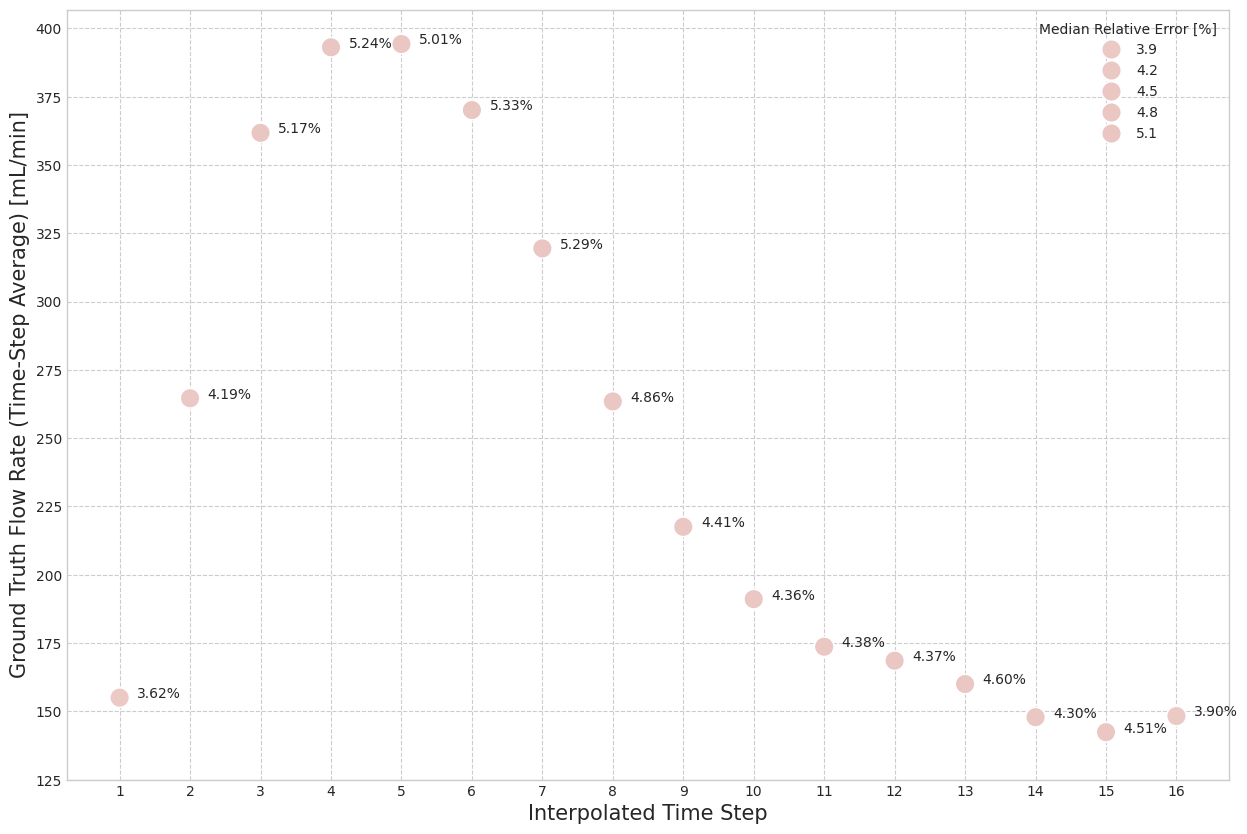

In [39]:
# 50th percentile (median) error
data_only = [
    "time_step",
    "gt_flow_rate",
    "pred_flow_rate",
    "gt_lumen_diameter",
    "pred_lumen_diameter",
    "gt_max_velocity",
    "pred_max_velocity"
]

time_average_flow_rate_gt_raw = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_flow_rate"].to_numpy()
)
relative_error_over_time_flow_rate_raw = (
    flow_df_raw.groupby("time_step")["relative_error_flow"].median().to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_flow_rate_gt_raw
sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_flow_rate_raw * 100, s=200, hue_norm=(0, 100)
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_flow_rate_raw]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.25, y[i]))

y_ticks = np.arange(125, 425, 25)
plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Flow Rate (Time-Step Average) [mL/min]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.yticks(y_ticks)
plt.legend(title="Median Relative Error [%]")
plt.grid(linestyle="--")

median_time_steps = np.median((flow_df_orig["time_step"].values + 1).flatten())

save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_flow_rate_median.svg")
plt.show()

##### Average Relative Error per time step (T = 16) for flow rate

/tmp/ipykernel_3594590/3175136901.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


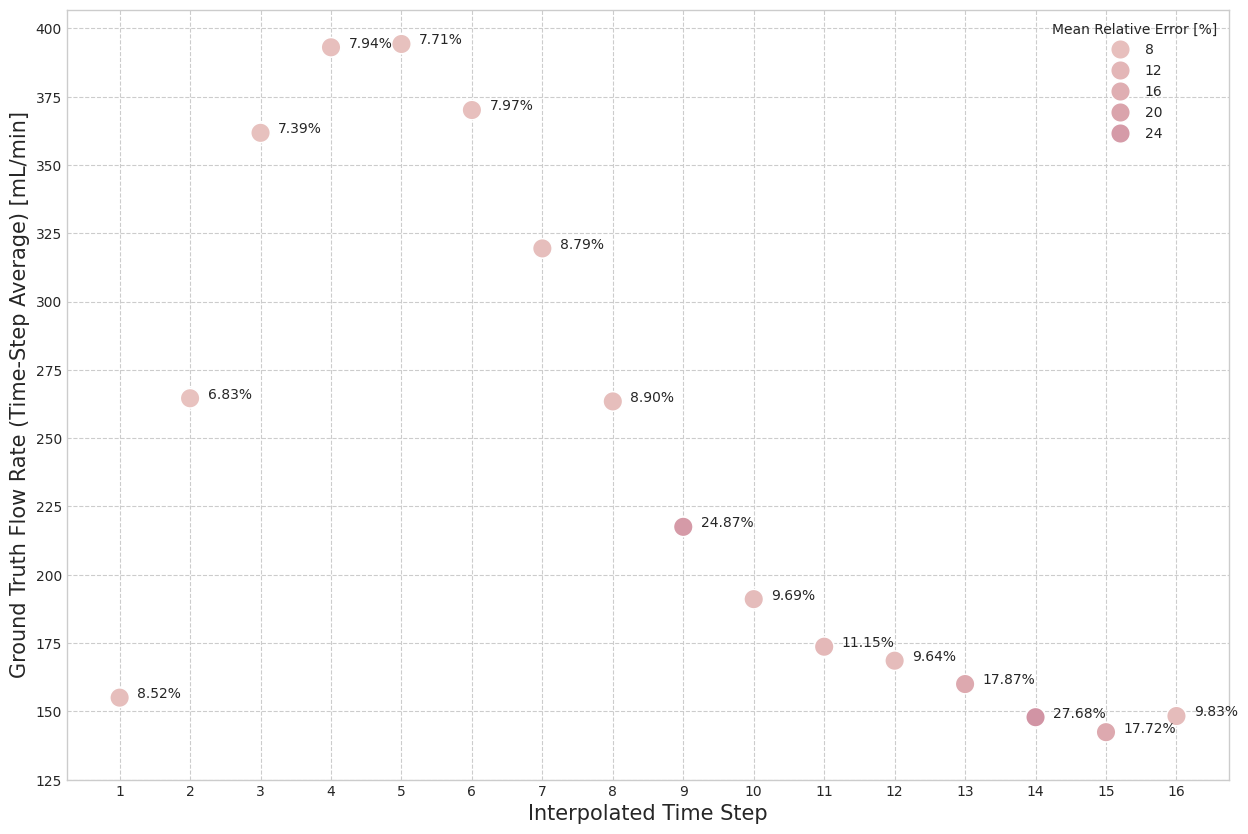

In [40]:
# Average error
data_only = [
    "time_step",
    "gt_flow_rate",
    "pred_flow_rate",
]

time_average_flow_rate_gt_raw = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_flow_rate"].to_numpy()
)
relative_error_over_time_flow_rate_raw = (
    flow_df_raw.groupby("time_step")["relative_error_flow"].mean().to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_flow_rate_gt_raw
sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_flow_rate_raw * 100, s=200, hue_norm=(0, 100)
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_flow_rate_raw]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.25, y[i]))

y_ticks = np.arange(125, 425, 25)
plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Flow Rate (Time-Step Average) [mL/min]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.yticks(y_ticks)
plt.legend(title="Mean Relative Error [%]")
plt.grid(linestyle="--")

median_time_steps = np.median((flow_df_orig["time_step"].values + 1).flatten())

save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_flow_rate_mean.svg")
plt.show()

##### P90 Relative Error per time step (T = 16) for flow rate

/tmp/ipykernel_3594590/716731364.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


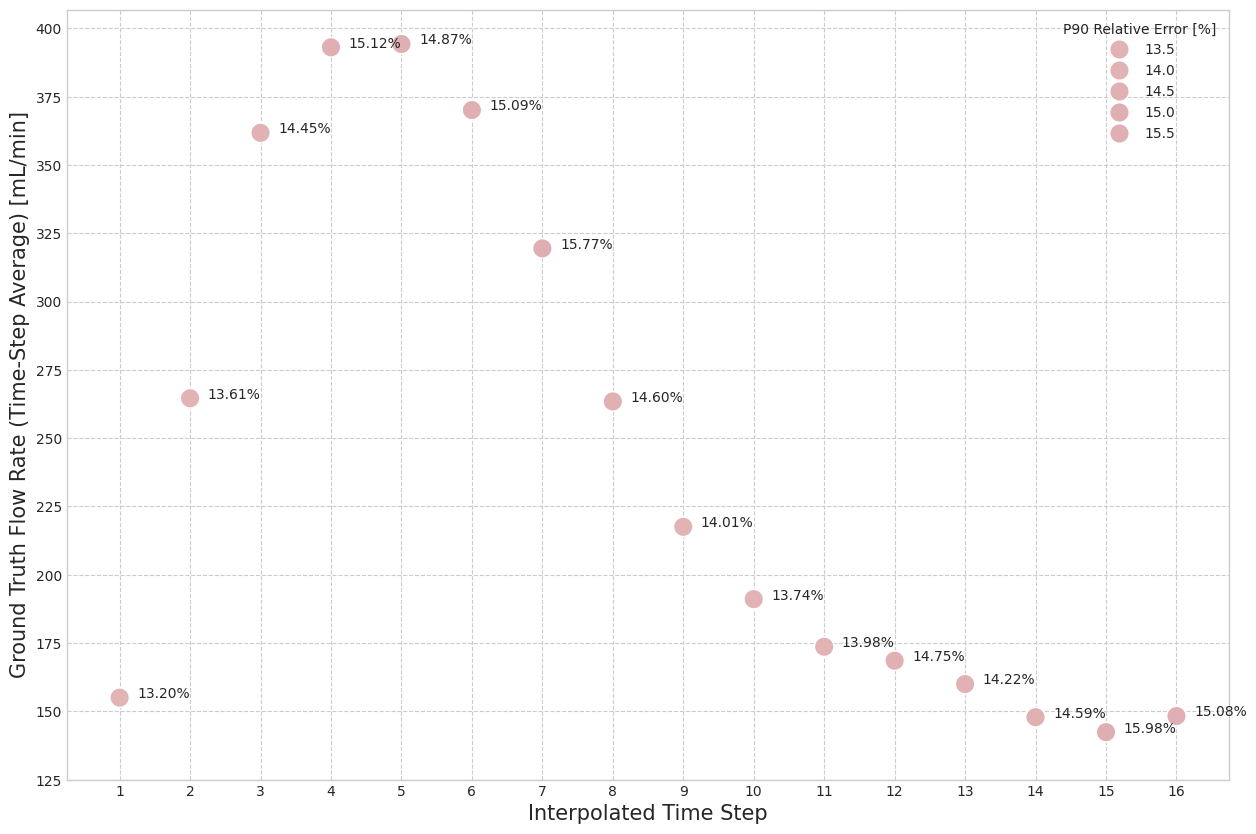

In [41]:
# 90th percentile
data_only = [
    "time_step",
    "gt_flow_rate",
    "pred_flow_rate",
]

time_average_flow_rate_gt_raw = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_flow_rate"].to_numpy()
)
relative_error_over_time_flow_rate_raw = (
    flow_df_raw.groupby("time_step")["relative_error_flow"].quantile(q=0.9).to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_flow_rate_gt_raw
sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_flow_rate_raw * 100, s=200, hue_norm=(0, 100)
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_flow_rate_raw]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.25, y[i]))

y_ticks = np.arange(125, 425, 25)
plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Flow Rate (Time-Step Average) [mL/min]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.yticks(y_ticks)
plt.legend(title="P90 Relative Error [%]")
plt.grid(linestyle="--")

median_time_steps = np.median((flow_df_orig["time_step"].values + 1).flatten())

save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_flow_rate_p90.svg")
plt.show()

##### Average Relative Error per time step (T = 16) for lumen diameter

/tmp/ipykernel_3594590/719093205.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


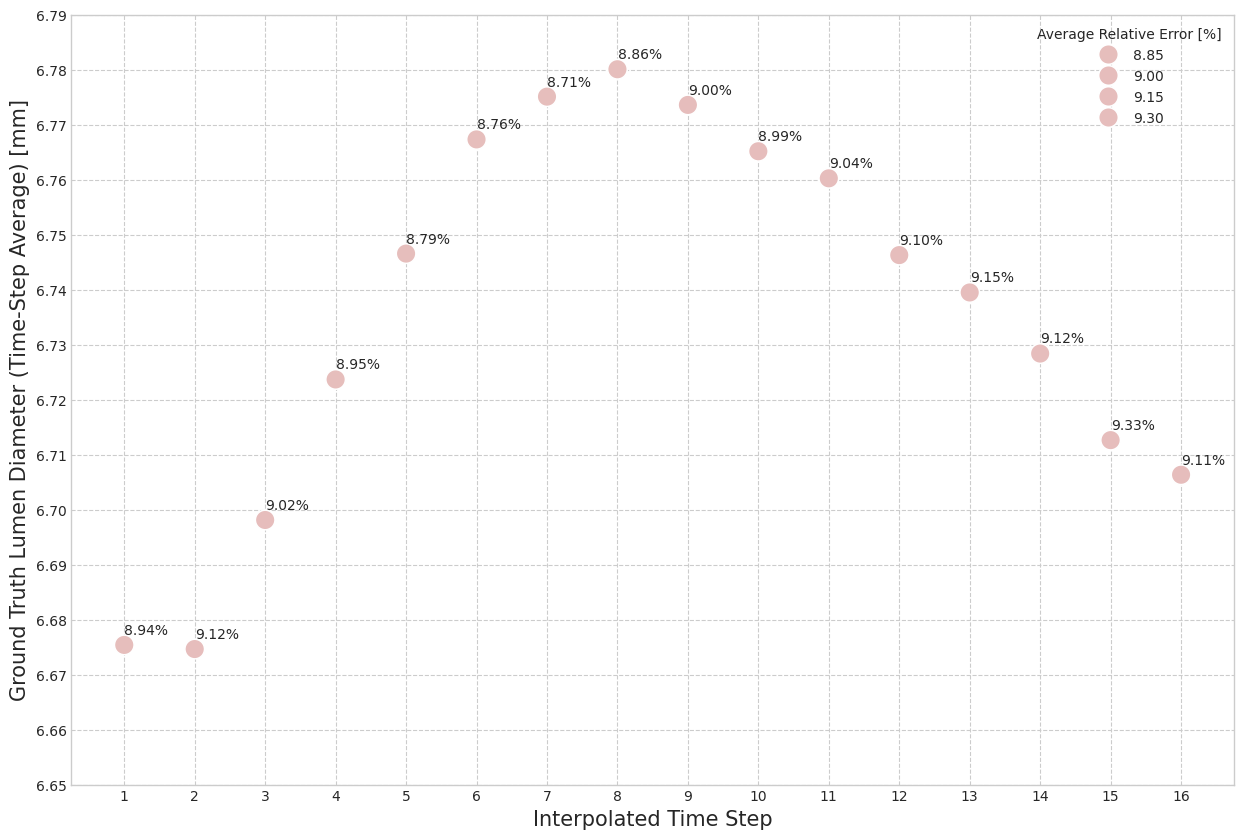

In [42]:
data_only = [
    "time_step",
    "gt_lumen_diameter",
    "pred_lumen_diameter",
]

time_average_lumen_diameter_gt = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_lumen_diameter"].to_numpy()
)
relative_error_over_time_lumen = (
    flow_df_raw.groupby("time_step")["relative_error_diameter"].mean().to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_lumen_diameter_gt
ax = sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_lumen * 100, hue_norm=(0, 100), s=200
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_lumen]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.002, y[i] + 0.002))

y_ticks = np.arange(6.65, 6.80, 0.01)
plt.yticks(y_ticks)
plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Lumen Diameter (Time-Step Average) [mm]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.legend(title="Average Relative Error [%]")
plt.grid(linestyle="--")
save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_lumen_diameter.svg")
plt.show()

##### Median Relative Error per time step (T = 16) for lumen diameter

/tmp/ipykernel_3594590/2472957414.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


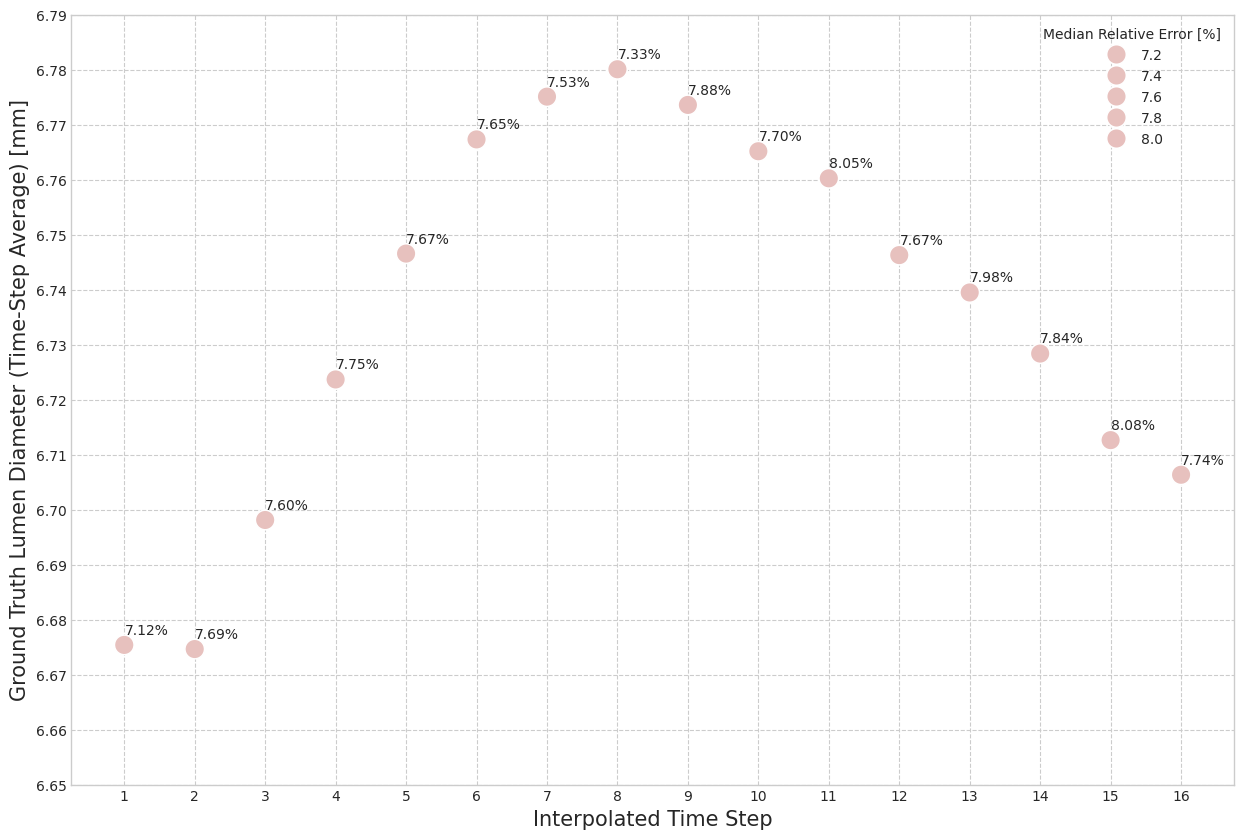

In [43]:
data_only = [
    "time_step",
    "gt_lumen_diameter",
    "pred_lumen_diameter",
]

time_average_lumen_diameter_gt = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_lumen_diameter"].to_numpy()
)
relative_error_over_time_lumen = (
    flow_df_raw.groupby("time_step")["relative_error_diameter"].median().to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_lumen_diameter_gt
ax = sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_lumen * 100, hue_norm=(0, 100), s=200
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_lumen]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.002, y[i] + 0.002))

y_ticks = np.arange(6.65, 6.80, 0.01)
plt.yticks(y_ticks)
plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Lumen Diameter (Time-Step Average) [mm]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.legend(title="Median Relative Error [%]")
plt.grid(linestyle="--")
save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_lumen_diameter_median.svg")
plt.show()

##### P90 Relative Error per time step (T = 16) for lumen diameter

/tmp/ipykernel_3594590/2299688770.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


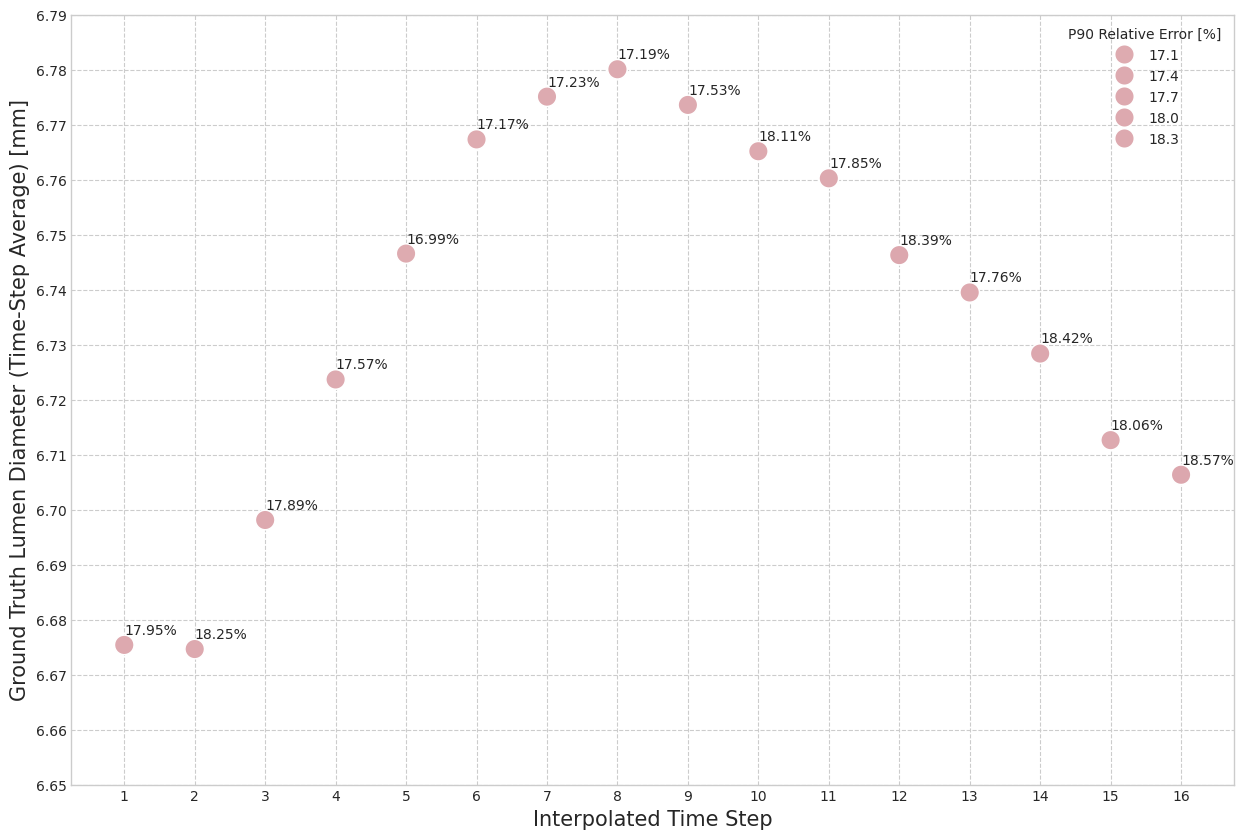

In [44]:
data_only = [
    "time_step",
    "gt_lumen_diameter",
    "pred_lumen_diameter",
]

time_average_lumen_diameter_gt = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_lumen_diameter"].to_numpy()
)
relative_error_over_time_lumen = (
    flow_df_raw.groupby("time_step")["relative_error_diameter"]
    .quantile(q=0.9)
    .to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_lumen_diameter_gt
ax = sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_lumen * 100, hue_norm=(0, 100), s=200
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_lumen]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.002, y[i] + 0.002))

y_ticks = np.arange(6.65, 6.80, 0.01)
plt.yticks(y_ticks)
plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Lumen Diameter (Time-Step Average) [mm]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.legend(title="P90 Relative Error [%]")
plt.grid(linestyle="--")
save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_lumen_diameter_p90.svg")
plt.show()

##### Average Relative Error per time step (T = 16) for max velocity

/tmp/ipykernel_3594590/2991009428.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


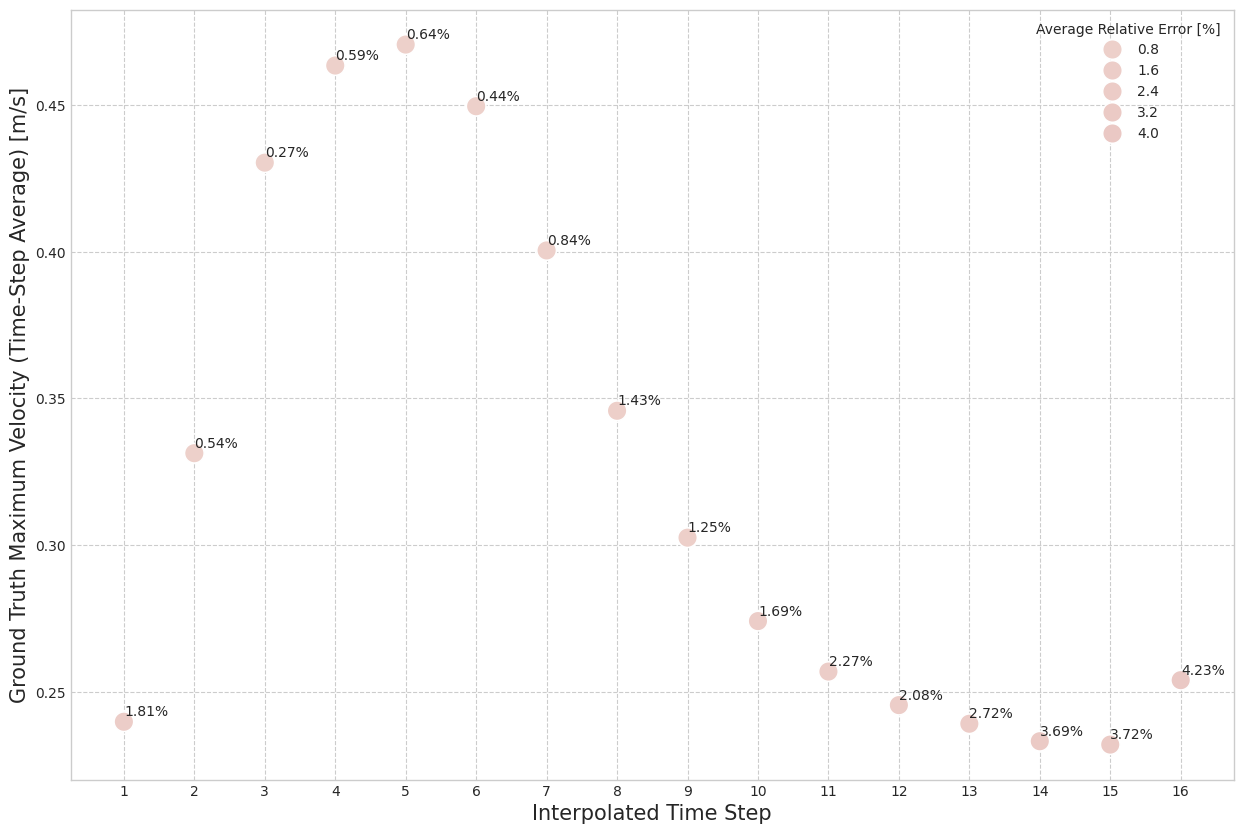

In [45]:
data_only = [
    "time_step",
    "gt_max_velocity",
    "pred_max_velocity",
]

time_average_max_velocity_gt = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_max_velocity"].to_numpy()
)
relative_error_over_time_max_velocity = (
    flow_df_raw.groupby("time_step")["relative_error_max_velocity"].mean().to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_max_velocity_gt
ax = sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_max_velocity * 100, hue_norm=(0, 100), s=200
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_max_velocity]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.002, y[i] + 0.002))

plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Maximum Velocity (Time-Step Average) [m/s]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.legend(title="Average Relative Error [%]")
plt.grid(linestyle="--")
save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_max_velocity_mean.svg")
plt.show()

##### Median Relative Error per time step (T = 16) for max velocity

/tmp/ipykernel_3594590/1780394571.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


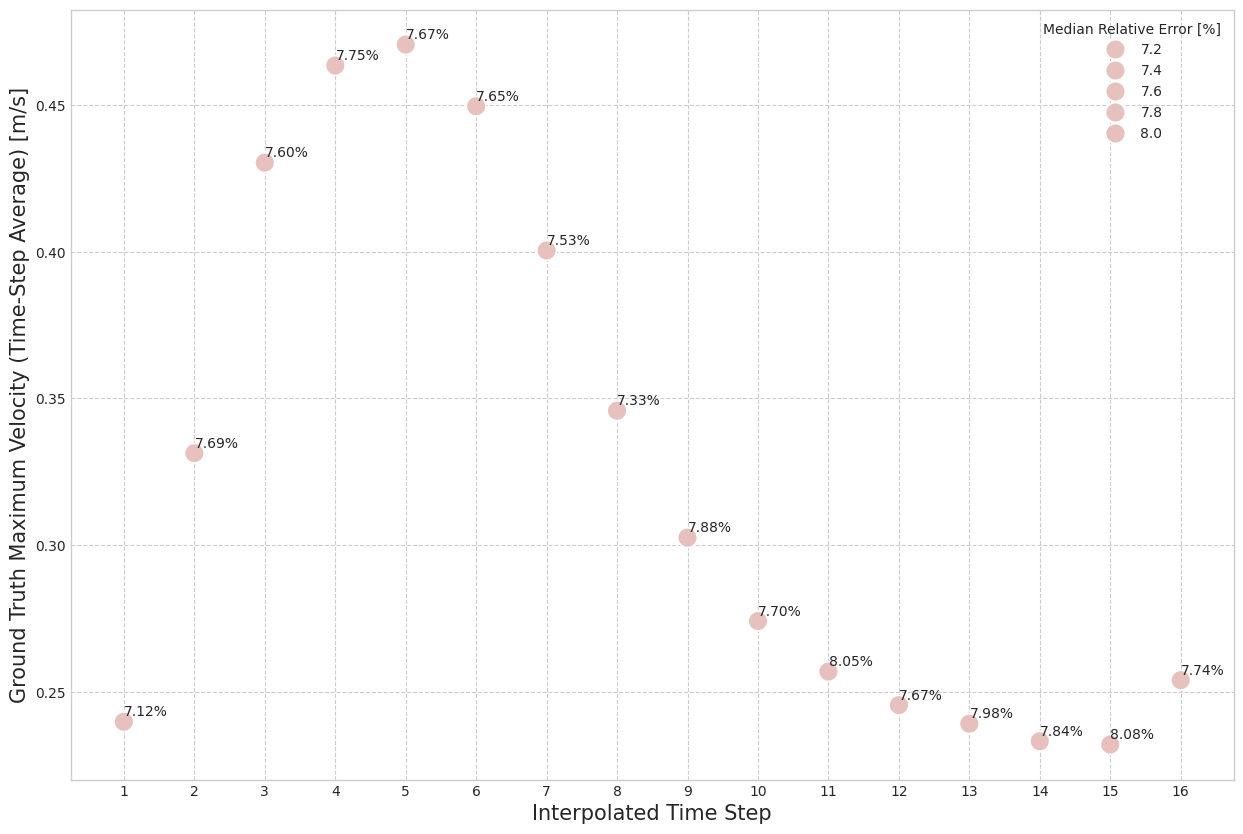

In [46]:
data_only = [
    "time_step",
    "gt_max_velocity",
    "pred_max_velocity",
]

time_average_max_velocity_gt = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_max_velocity"].to_numpy()
)
relative_error_over_time_lumen = (
    flow_df_raw.groupby("time_step")["relative_error_diameter"].median().to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_max_velocity_gt
ax = sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_lumen * 100, hue_norm=(0, 100), s=200
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_lumen]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.002, y[i] + 0.002))

plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Maximum Velocity (Time-Step Average) [m/s]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.legend(title="Median Relative Error [%]")
plt.grid(linestyle="--")
save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_max_velocity_median.svg")
plt.show()

##### P90 Relative Error per time step (T = 16) for max velocity

/tmp/ipykernel_3594590/529528221.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


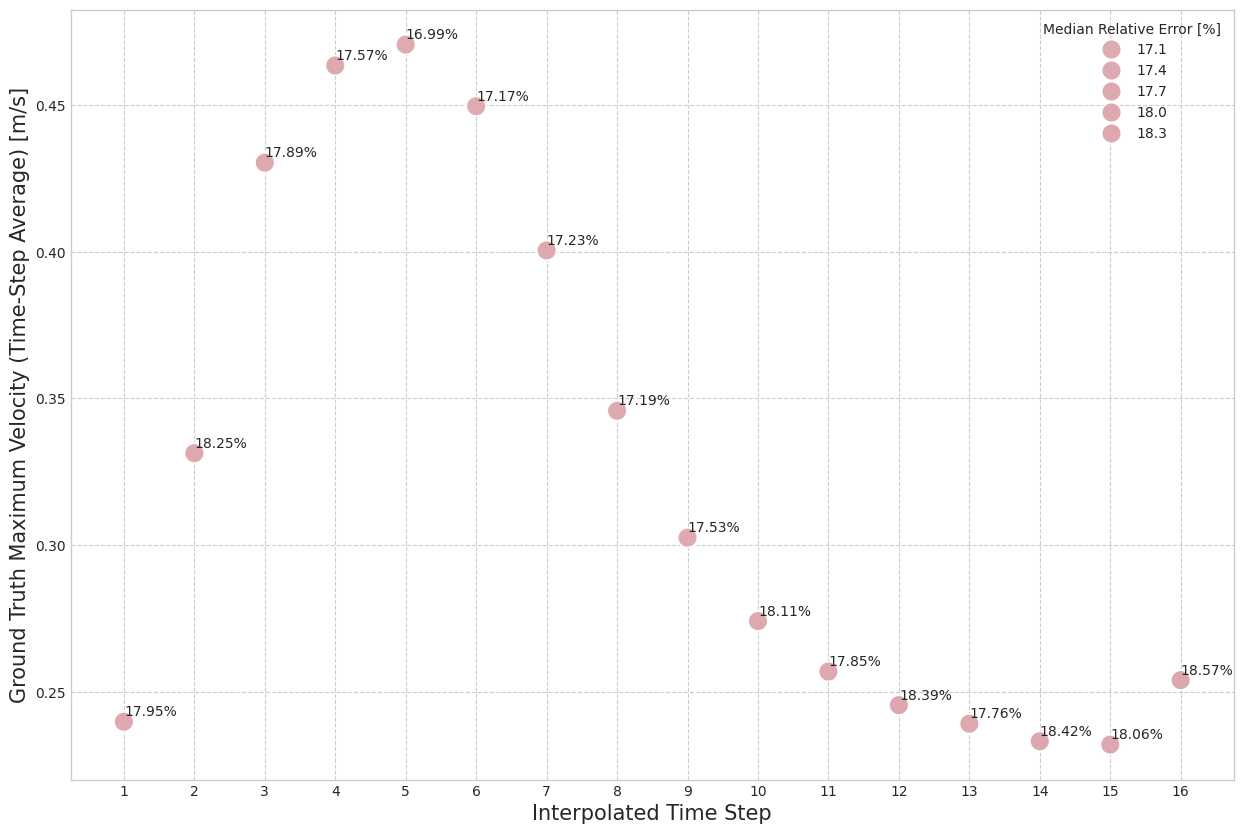

In [47]:
data_only = [
    "time_step",
    "gt_max_velocity",
    "pred_max_velocity",
]

time_average_max_velocity_gt = (
    flow_df_raw[data_only].groupby("time_step").mean()["gt_max_velocity"].to_numpy()
)
relative_error_over_time_lumen = (
    flow_df_raw.groupby("time_step")["relative_error_diameter"]
    .quantile(q=0.9)
    .to_numpy()
)

total_time_steps = 16
plt.style.use("seaborn-whitegrid")

plt.figure(figsize=(15, 10))
x = np.arange(1, total_time_steps + 1)
y = time_average_max_velocity_gt
ax = sns.scatterplot(
    x=x, y=y, hue=relative_error_over_time_lumen * 100, hue_norm=(0, 100), s=200
)

# Annotate percentages
z = [f"{err * 100:.2f}%" for err in relative_error_over_time_lumen]
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i] + 0.002, y[i] + 0.002))


plt.xlabel("Interpolated Time Step")
plt.ylabel("Ground Truth Maximum Velocity (Time-Step Average) [m/s]")
plt.xticks(np.arange(1, total_time_steps + 1))
plt.legend(title="Median Relative Error [%]")
plt.grid(linestyle="--")
save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "error_over_time_max_velocity_p90.svg")
plt.show()

##### Error over time for best and worst sample

In [48]:
# Find the best performing sample
best_file = (
    flow_df_raw.groupby("sample")["relative_error_flow"]
    .apply(lambda x: x.to_numpy().mean())
    .idxmin()
)

# Find the worst performing sample
worst_file = (
    flow_df_raw.groupby("sample")["relative_error_flow"]
    .apply(lambda x: x.to_numpy().mean())
    .idxmax()
)

colors = ["blue", "white", "red"]  # Blue for -1, White for 0, Red for 1
custom_cmap = ListedColormap(colors)

best_pred_folder = Path(
    f"{model_output_directory}/UNet3D/velocities/Interp_16/ensemble/"
)

best_nib_gt = nib.load(Path(test_labels["velocities"]) / best_file)
best_nib_pred = nib.load(best_pred_folder / best_file)

worst_nib_gt = nib.load(Path(test_labels["velocities"]) / worst_file)
worst_nib_pred = nib.load(best_pred_folder / worst_file)

overlap_best = best_nib_pred.get_fdata().squeeze() - best_nib_gt.get_fdata().squeeze()

overlap_worst = (
    worst_nib_pred.get_fdata().squeeze() - worst_nib_gt.get_fdata().squeeze()
)

##### Visualize Prediction Errors over Time 

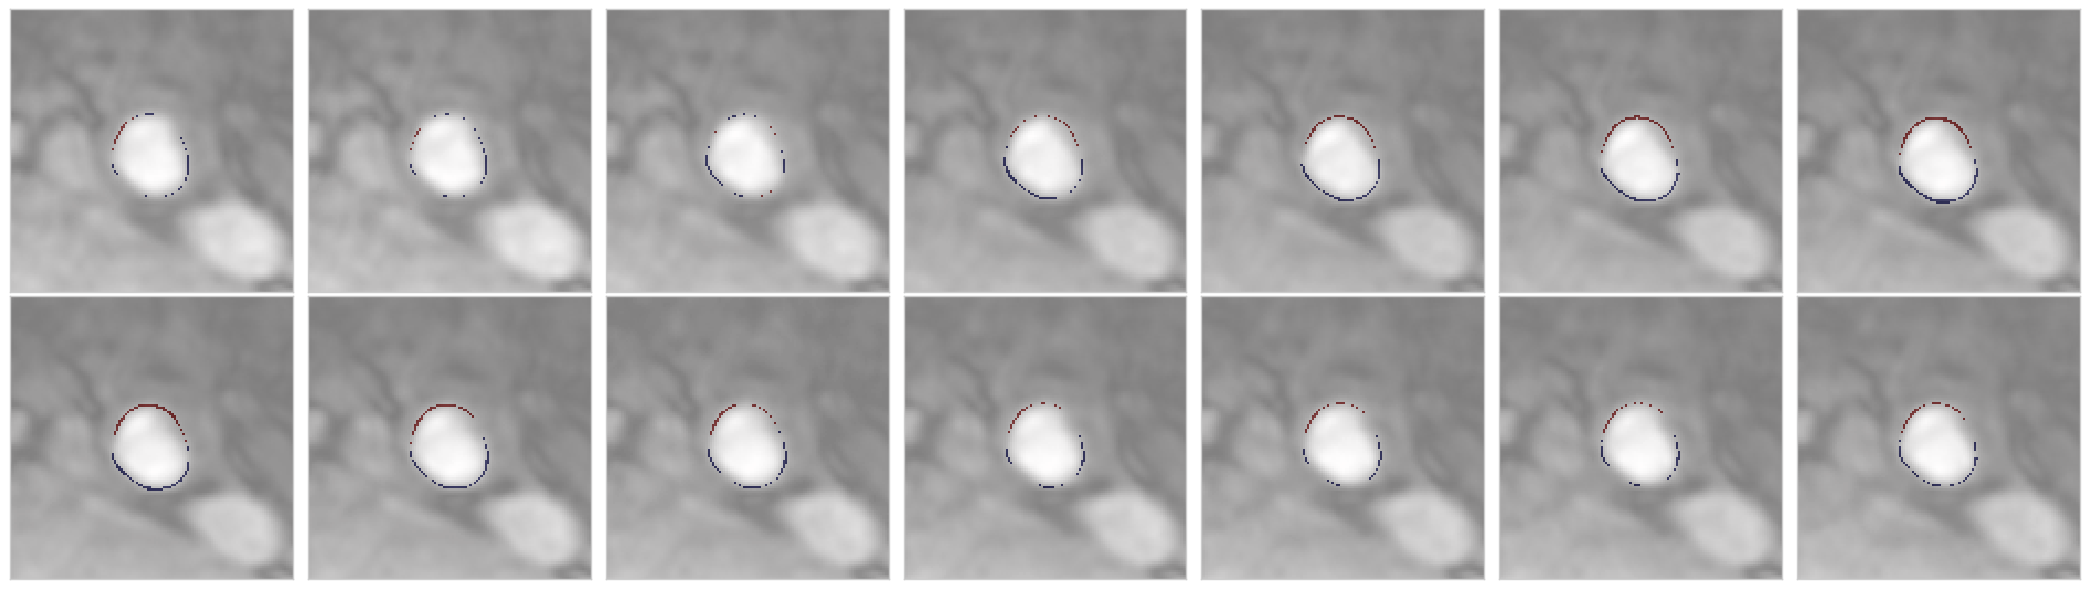

In [49]:
magnitude_img = (
    nib.load(Path(test_images["magnitude"]) / f"{best_file.split('.')[0]}_0000.nii.gz")
    .get_fdata()
    .squeeze()
)

magnitude_imgs = [magnitude_img[..., i] for i in range(magnitude_img.shape[-1])]

error_imgs = [overlap_best[..., i] for i in range(overlap_best.shape[-1])]

grid = isns.ImageGrid(
    overlap_best, cmap=custom_cmap, vmin=-1, vmax=1, col_wrap=7, cbar=False
)

for ax, base_img, overlay in zip(grid.axes.flat, error_imgs, magnitude_imgs):
    # Plot the base image
    ax.imshow(base_img, cmap="seismic", norm=CenteredNorm())

    # Add the overlay
    overlay_plot = ax.imshow(overlay, alpha=0.5, cmap="gray")

save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "errors_best_sample.svg")

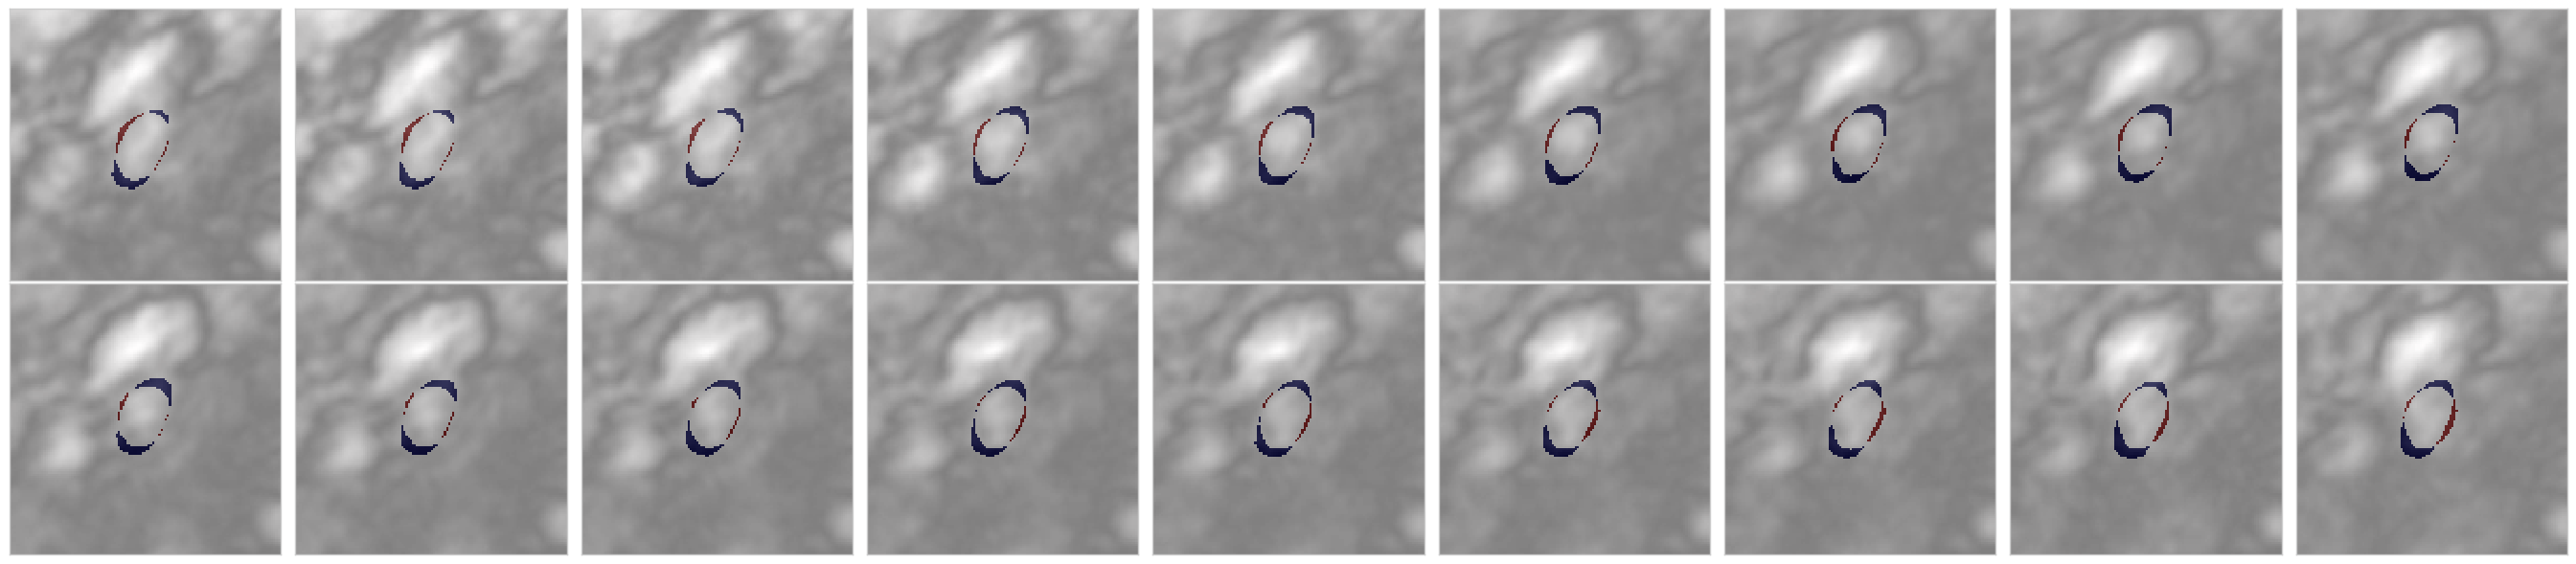

In [50]:
magnitude_img = (
    nib.load(Path(test_images["magnitude"]) / f"{worst_file.split('.')[0]}_0000.nii.gz")
    .get_fdata()
    .squeeze()
)

magnitude_imgs = [magnitude_img[..., i] for i in range(magnitude_img.shape[-1])]

error_imgs = [overlap_worst[..., i] for i in range(overlap_worst.shape[-1])]

grid = isns.ImageGrid(
    overlap_worst, cmap=custom_cmap, vmin=-1, vmax=1, col_wrap=9, cbar=False
)

for ax, base_img, overlay in zip(grid.axes.flat, error_imgs, magnitude_imgs):
    # Plot the base image
    ax.imshow(base_img, cmap="seismic", norm=CenteredNorm())

    # Add the overlay
    overlay_plot = ax.imshow(overlay, alpha=0.5, cmap="gray")

save_dir = Path(save_path) / "error_analysis" / "time_steps"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "errors_worst_sample.svg")

##### Error Distribution Heatmap

In [51]:
df = pd.read_excel(
    f"{model_output_directory}/UNet3D/velocities/Interp_16/evaluation_ensemble/data.xlsx"
)

flow_df = df[
    ["sample", "time_step", "gt_flow_rate", "pred_flow_rate", "pred_lumen_diameter"]
]

data_cols = [
    "time_step",
    "gt_flow_rate",
    "pred_flow_rate",
    "gt_lumen_diameter",
    "pred_lumen_diameter",
]

flow_df = df[
    [
        "sample",
        "time_step",
        "gt_flow_rate",
        "pred_flow_rate",
        "gt_lumen_diameter",
        "pred_lumen_diameter",
    ]
]
flow_df["absolute_error_flow"] = (
    flow_df["pred_flow_rate"] - flow_df["gt_flow_rate"]
).abs()
flow_df["relative_error_flow"] = (
    (flow_df["pred_flow_rate"] - flow_df["gt_flow_rate"]) / flow_df["gt_flow_rate"]
).abs()
flow_df["absolute_error_diameter"] = (
    flow_df["pred_lumen_diameter"] - flow_df["gt_lumen_diameter"]
).abs()

In [52]:
filenames = list(flow_df["sample"].unique())

error_arrays = []
gt_arrays = []
total_timepoints = 0
for filename in filenames:
    gt_arr = nib.load(Path(test_labels["velocities"]) / filename).get_fdata().squeeze()
    pred_arr = nib.load(best_pred_folder / filename).get_fdata().squeeze()
    error_arrays.append((pred_arr - gt_arr).sum(axis=-1))
    gt_arrays.append(gt_arr.sum(axis=-1))
    total_timepoints += gt_arr.shape[-1]

err_sum = np.array(error_arrays).sum(axis=0) / total_timepoints

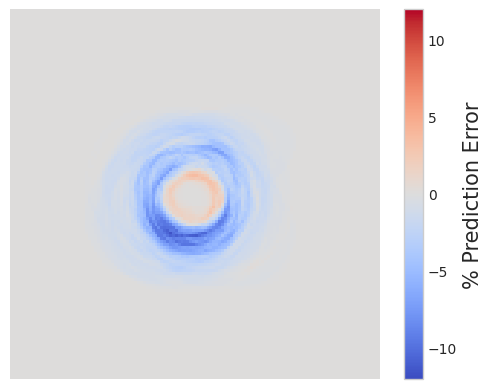

In [53]:
vmax = np.ceil(np.max(np.abs(err_sum * 100)))

plt.imshow(err_sum*100, cmap='coolwarm', vmin=-vmax, vmax=vmax)
cbar = plt.colorbar(label='% Prediction Error')
plt.grid(False)
plt.axis('off')

save_dir = Path(save_path) / "distributions"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "pixel_prediction_dist.svg")

##### Compare results over time for the best model by plane (1-8)

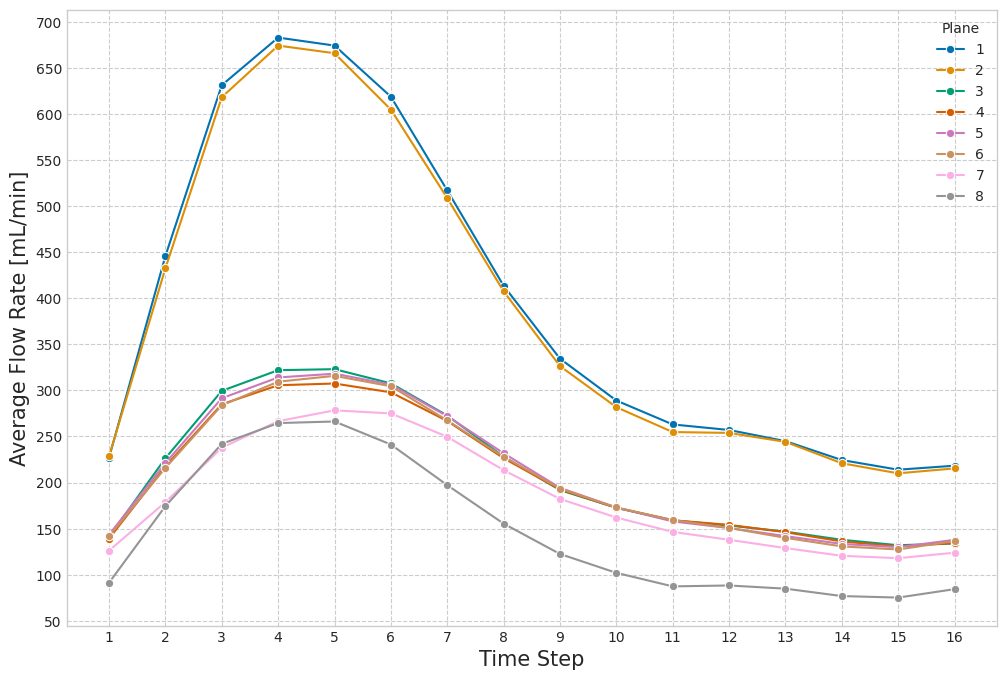

In [55]:
# Reference: Average ground truth flow rate

median_time_steps = 16

d = {"Time Step": np.arange(1, median_time_steps + 1)}

for i in range(1, 9):
    slice1_df = flow_df_raw[flow_df_raw["sample"].str.contains(f"slice{i}")]
    gt_flow_t = slice1_df.groupby("time_step")["gt_flow_rate"].mean().to_numpy()
    d[i] = gt_flow_t

df_slice_comp = pd.melt(
    pd.DataFrame(d), ["Time Step"], var_name="Plane", value_name="Flow Rate"
)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", 8)
ax = sns.lineplot(
    data=df_slice_comp,
    x="Time Step",
    y="Flow Rate",
    hue="Plane",
    # hue_order=range(1,9),
    palette=colors,
    marker="o",
)
ax.set_ylabel("Average Flow Rate [mL/min]")
plt.xticks(np.arange(1, median_time_steps + 1))
y_ticks = np.arange(50, 700.5, 50)
plt.yticks(y_ticks)
plt.grid(linestyle="--")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
save_dir = Path(save_path) / "error_analysis" / "planes"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "avg_gt_flow_rate.svg")

##### Average Error Flow Rate

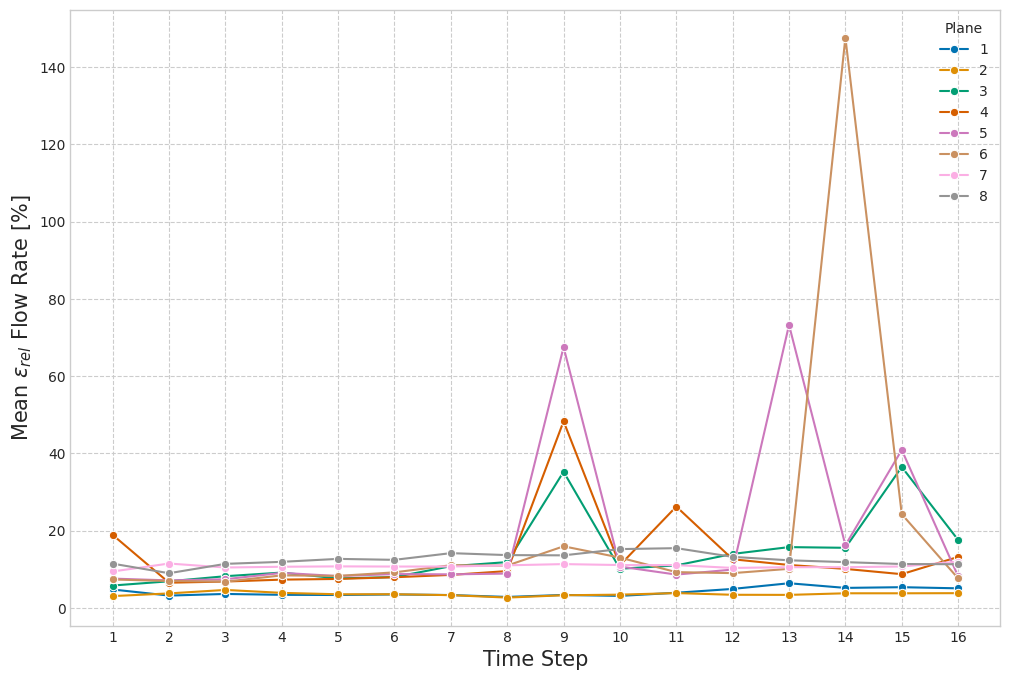

In [56]:
d = {"Time Step": np.arange(1, median_time_steps + 1)}

for i in range(1, 9):
    d[i] = (
        flow_df_raw[flow_df_raw["sample"].str.contains(f"slice{i}")]
        .groupby("time_step")["relative_error_flow"].mean().to_numpy()* 100
    )

df_plane_err_flow_rate = pd.melt(
    pd.DataFrame(d), ["Time Step"], var_name="Plane", value_name="Relative Error"
)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", 8)
ax = sns.lineplot(
    data=df_plane_err_flow_rate,
    x="Time Step",
    y="Relative Error",
    hue="Plane",
    palette=colors,
    marker="o",
)
ax.set_ylabel("Mean $\epsilon_{rel}$ Flow Rate [%]")
plt.xticks(np.arange(1, median_time_steps + 1))
plt.grid(linestyle="--")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
save_dir = Path(save_path) / "error_analysis" / "planes"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "avg_rel_err_flow_rate.svg")

##### P90 Error Flow Rate

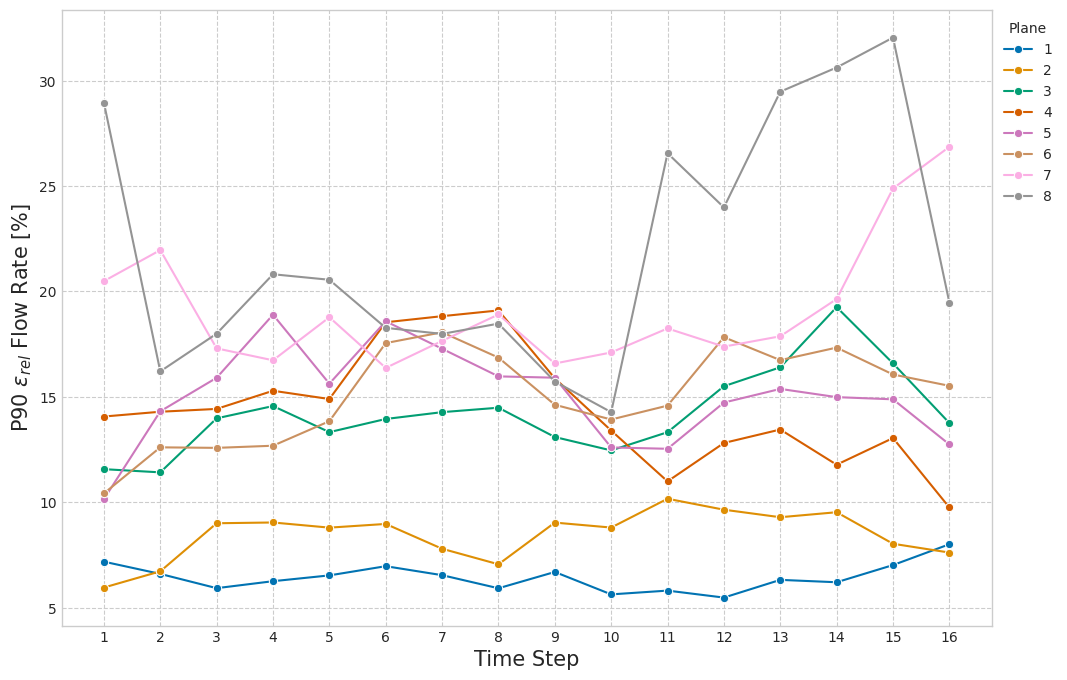

In [57]:
d = {"Time Step": np.arange(1, median_time_steps + 1)}

for i in range(1, 9):
    d[i] = (
        flow_df_raw[flow_df_raw["sample"].str.contains(f"slice{i}")]
        .groupby("time_step")["relative_error_flow"]
        .quantile(q=0.90)
        .to_numpy()
        * 100
    )

df_plane_err_flow_rate = pd.melt(
    pd.DataFrame(d), ["Time Step"], var_name="Plane", value_name="Relative Error"
)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", 8)
ax = sns.lineplot(
    data=df_plane_err_flow_rate,
    x="Time Step",
    y="Relative Error",
    hue="Plane",
    palette=colors,
    marker="o",
)
ax.set_ylabel("P90 $\epsilon_{rel}$ Flow Rate [%]")
plt.xticks(np.arange(1, median_time_steps + 1))
plt.grid(linestyle="--")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
save_dir = Path(save_path) / "error_analysis" / "planes"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "p90_rel_err_flow_rate.svg")

##### Average Error Lumen Diameter

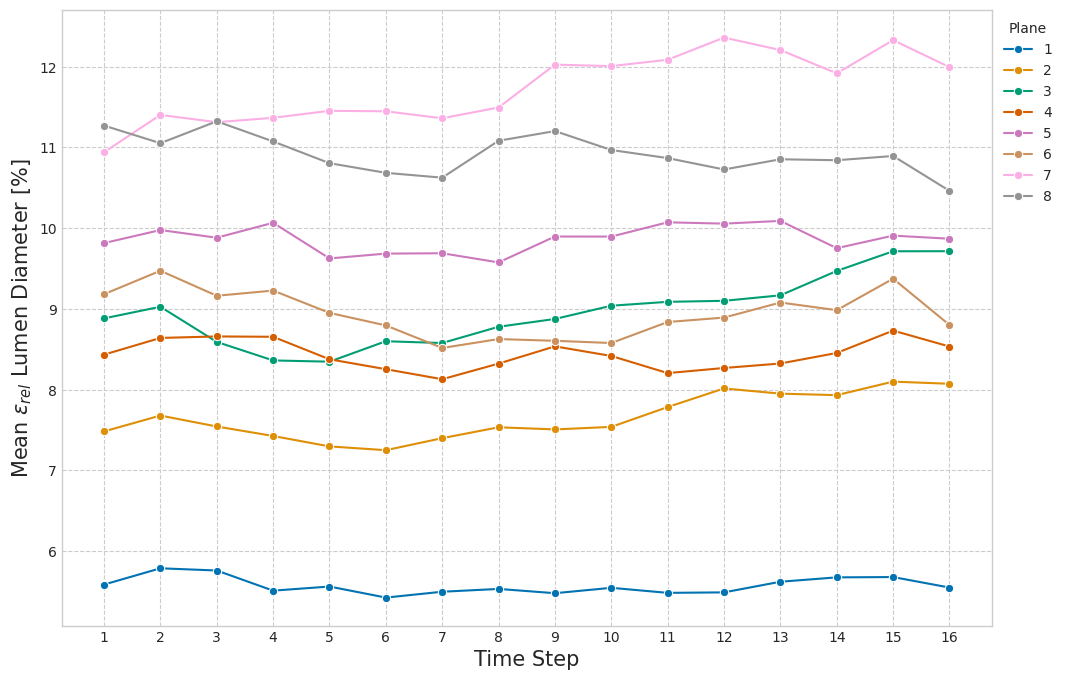

In [58]:
d = {"Time Step": np.arange(1, median_time_steps + 1)}

for i in range(1, 9):
    d[i] = (
        flow_df_raw[flow_df_raw["sample"].str.contains(f"slice{i}")]
        .groupby("time_step")["relative_error_diameter"]
        .mean()
        .to_numpy()
        * 100
    )

df_plane_err_flow_rate = pd.melt(
    pd.DataFrame(d), ["Time Step"], var_name="Plane", value_name="Relative Error"
)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", 8)
ax = sns.lineplot(
    data=df_plane_err_flow_rate,
    x="Time Step",
    y="Relative Error",
    hue="Plane",
    hue_order=range(1, 9),
    palette=colors,
    marker="o",
)
ax.set_ylabel("Mean $\epsilon_{rel}$ Lumen Diameter [%]")
plt.xticks(np.arange(1, median_time_steps + 1))
plt.grid(linestyle="--")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
save_dir = Path(save_path) / "error_analysis" / "planes"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "avg_rel_err_lumen_diameter.svg")

##### Median Error Flow Rate

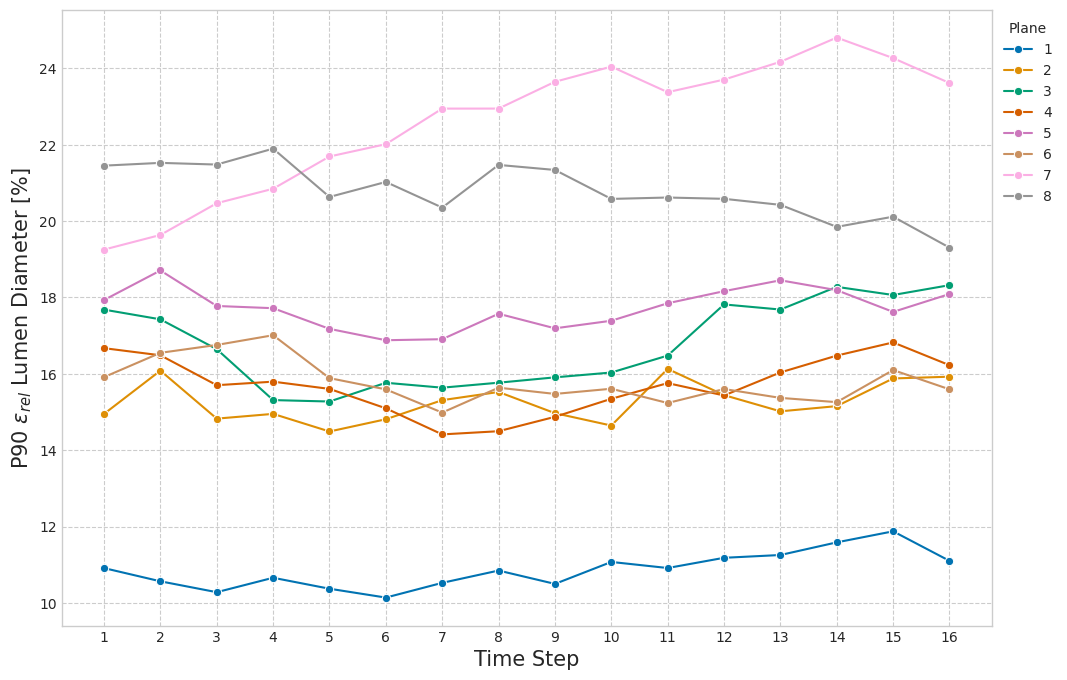

In [59]:
d = {"Time Step": np.arange(1, median_time_steps + 1)}

for i in range(1, 9):
    d[i] = (
        flow_df_raw[flow_df_raw["sample"].str.contains(f"slice{i}")]
        .groupby("time_step")["relative_error_diameter"]
        .quantile(q=0.9)
        .to_numpy()
        * 100
    )

df_plane_err_flow_rate = pd.melt(
    pd.DataFrame(d), ["Time Step"], var_name="Plane", value_name="Relative Error"
)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", 8)
ax = sns.lineplot(
    data=df_plane_err_flow_rate,
    x="Time Step",
    y="Relative Error",
    hue="Plane",
    hue_order=range(1, 9),
    palette=colors,
    marker="o",
)
ax.set_ylabel("P90 $\epsilon_{rel}$ Lumen Diameter [%]")
plt.xticks(np.arange(1, median_time_steps + 1))
plt.grid(linestyle="--")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
save_dir = Path(save_path) / "error_analysis" / "planes"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "p90_rel_err_lumen_diameter.svg")

##### Average Error Maximum Velocity

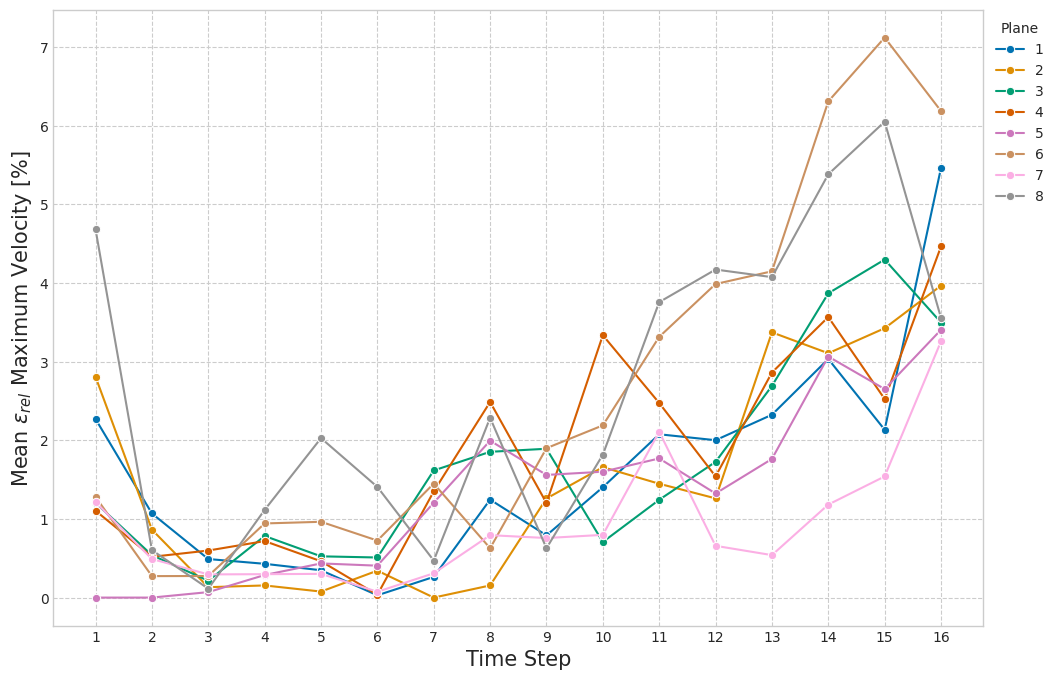

In [60]:
d = {"Time Step": np.arange(1, median_time_steps + 1)}

for i in range(1, 9):
    d[i] = (
        flow_df_raw[flow_df_raw["sample"].str.contains(f"slice{i}")]
        .groupby("time_step")["relative_error_max_velocity"].mean().to_numpy() * 100
    )

df_plane_err_flow_rate = pd.melt(
    pd.DataFrame(d), ["Time Step"], var_name="Plane", value_name="Relative Error"
)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", 8)
ax = sns.lineplot(
    data=df_plane_err_flow_rate,
    x="Time Step",
    y="Relative Error",
    hue="Plane",
    hue_order=range(1, 9),
    palette=colors,
    marker="o",
)
ax.set_ylabel("Mean $\epsilon_{rel}$ Maximum Velocity [%]")
plt.xticks(np.arange(1, median_time_steps + 1))
plt.grid(linestyle="--")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
save_dir = Path(save_path) / "error_analysis" / "planes"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "avg_rel_err_max_velocity.svg")

##### P90 Error Maximum Velocity

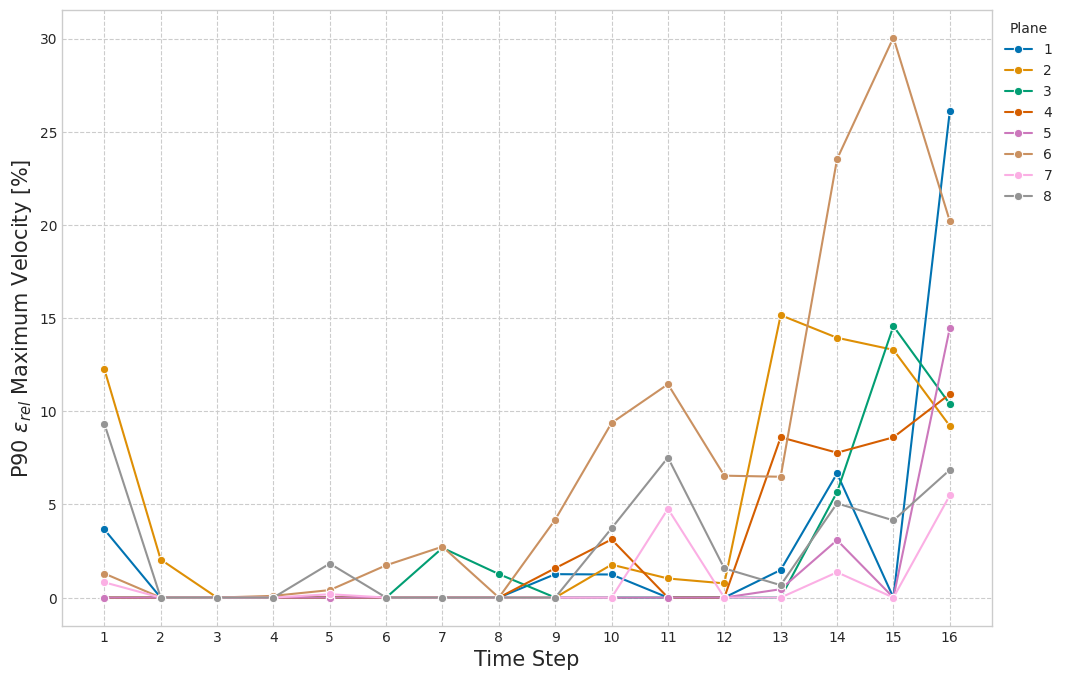

In [61]:
d = {"Time Step": np.arange(1, median_time_steps + 1)}

for i in range(1, 9):
    d[i] = (
        flow_df_raw[flow_df_raw["sample"].str.contains(f"slice{i}")]
        .groupby("time_step")["relative_error_max_velocity"]
        .quantile(q=0.9)
        .to_numpy()
        * 100
    )

df_plane_err_flow_rate = pd.melt(
    pd.DataFrame(d), ["Time Step"], var_name="Plane", value_name="Relative Error"
)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", 8)
ax = sns.lineplot(
    data=df_plane_err_flow_rate,
    x="Time Step",
    y="Relative Error",
    hue="Plane",
    hue_order=range(1, 9),
    palette=colors,
    marker="o",
)
ax.set_ylabel("P90 $\epsilon_{rel}$ Maximum Velocity [%]")
plt.xticks(np.arange(1, median_time_steps + 1))
plt.grid(linestyle="--")
sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
save_dir = Path(save_path) / "error_analysis" / "planes"
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / "p90_rel_err_max_velocity.svg")